<div style="max-height: 400px; overflow: hidden;">
<img src="./retail_demand_cover_compress.png">
</div>

<p style="font-size:25px; color:#496595">Problem Statement</p>

We have data of **Corporación Favorita** stores located in **Ecuador**, we need to predict the sales of thousands of product families sold at thses stores. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary holiday and oil price information that may be useful in building our models.

<p style="font-size:25px; color:#496595">Data Description</p>

> **train.csv**
>
> * The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
>
> * **store_nbr** identifies the store at which the products are sold.
>
> * **family** identifies the type of product sold.
>
> * **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
>
> * **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


> **test.csv**
>
> * The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.
>
> * The dates in the test data are for the 15 days after the last date in the training data.


> **stores.csv**
>
> * Store metadata, including **city**, **state**, **type**, and **cluster**.
>
> * **cluster** is a grouping of similar stores.


> **oil.csv**
>
> * Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)


> **holidays_events.csv**
>
> * Holidays and Events, with metadata
>
> * NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
>
> * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


> **transactions.csv**
>
> * It contains **date**, **store_nbr**, **transactions**. Where **transactions** is the count of sales transactions at the store for the day.


<div class="alert alert-block alert-info">
    <b>Additional Notes:</b>
    <ul>
        <li>
           Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
        </li>
        <li>
            A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.
        </li>
    </ul>
    <p><b>You can get the data from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">here</a>.</b></p>
</div>

<p style="font-size:25px; color:#496595">Impoting the libraries</p>

In [98]:
import numpy as np
import pandas as pd
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import os
import math
import warnings
import itertools
from plotly.subplots import make_subplots
import plotly.offline as offline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from concurrent.futures import ThreadPoolExecutor

pool_executor = ThreadPoolExecutor()

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15

COLORS = list(sns.color_palette("husl", 8))

offline.init_notebook_mode(connected = True)
warnings.filterwarnings('ignore')

<p style="font-size:25px; color:#496595">Data Reading and Sanitation checks</p>
 
* Let's check what datasets are available in the directory.

In [99]:
# Replace with your own path
for dirname, _, filenames in os.walk('../../../Kaggle_input/input/store_sales_time_series_forecasting/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../../Kaggle_input/input/store_sales_time_series_forecasting/test_with_features.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/sample_submission.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/test.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/train.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/holidays_events.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/test_merged.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/train_merged_v2.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/stores.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/oil.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/transactions.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/train_with_features.csv
../../../Kaggle_input/input/store_sales_time_series_forecasting/train_merged.csv


* Reading the datasets

In [104]:
train = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/train.csv')
test = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/test.csv')
sample_submission = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/sample_submission.csv')
holidays = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/holidays_events.csv')
oil_price = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/oil.csv')
stores = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/stores.csv')
transactions = pd.read_csv('../../../Kaggle_input/input/store_sales_time_series_forecasting/transactions.csv')

* Checking the how many records we have in the datasets, to get an idea of the data size.

In [105]:
# Lets check the shape of these datasets
shapes = pd.DataFrame({'train': train.shape, 
                       'test': test.shape, 
                       'sample_submission': sample_submission.shape, 
                       'holidays': holidays.shape, 
                       'oil_price': oil_price.shape, 
                       'stores': stores.shape,
                       'transactions': transactions.shape}, index=['Rows', 'Columns']).reset_index()

row_list = []
for row in shapes.iterrows():
    row_list.append(row[1].tolist())
    
headings = shapes.columns.tolist()
headings[0] = " "
formatted_headings = [f"<span style='font-size:20px'><b>{val}</b></span>" for val in headings]

In [106]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, .9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2],
    y=[1.6] * 8,
    mode="text", 
    text=formatted_headings,
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, .9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2],
    y=[1.1] * 8,
    mode="text", 
    text=row_list[0],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, .9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2],
    y=[0.6] * 8,
    mode="text", 
    text=row_list[1],
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.0, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=1300, 
                  title='Records in the Datasets', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.4,7], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=20, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=10,b=0,r=80), 
    )

* Let's check the data types of different columns in the datasets

In [107]:
dtype_table_head = ['train'] * train.shape[1]
dtype_table_head.extend(['test'] * test.shape[1])
dtype_table_head.extend(['holidays'] * holidays.shape[1])
dtype_table_head.extend(['oil_price'] * oil_price.shape[1])
dtype_table_head.extend(['stores'] * stores.shape[1])
dtype_table_head.extend(['transactions'] * transactions.shape[1])
# dtype_table_head

dtype_table_col = train.columns.tolist()
dtype_table_col.extend(test.columns.tolist())
dtype_table_col.extend(holidays.columns.tolist())
dtype_table_col.extend(oil_price.columns.tolist())
dtype_table_col.extend(stores.columns.tolist())
dtype_table_col.extend(transactions.columns.tolist())
# dtype_table_col

dtype_table_dtype = [train[col].dtype for col in train.columns.tolist()]
dtype_table_dtype.extend([test[col].dtype for col in test.columns.tolist()])
dtype_table_dtype.extend([holidays[col].dtype for col in holidays.columns.tolist()])
dtype_table_dtype.extend([oil_price[col].dtype for col in oil_price.columns.tolist()])
dtype_table_dtype.extend([stores[col].dtype for col in stores.columns.tolist()])
dtype_table_dtype.extend([transactions[col].dtype for col in transactions.columns.tolist()])
# dtype_table_dtype

In [108]:
# Create a structured table to represent data types
data_type_table = pd.DataFrame({
    'DataFrame': dtype_table_head,
    'Column Name': dtype_table_col,
    'Data Type': dtype_table_dtype
})
data_type_table

,DataFrame,Column Name,Data Type
0,train,id,int64
1,train,date,object
2,train,store_nbr,int64
3,train,family,object
4,train,sales,float64
5,train,onpromotion,int64
6,test,id,int64
7,test,date,object
8,test,store_nbr,int64
9,test,family,object


* Let's convert all date columns to datetime

In [109]:
# train:
train['date'] = pd.to_datetime(train['date'])

# transactions:
transactions['date'] = pd.to_datetime(transactions['date'])

# holidays:
holidays['date'] = pd.to_datetime(holidays['date'])

#oil_price:
oil_price['date'] = pd.to_datetime(oil_price['date'])

# test
test['date'] = pd.to_datetime(test['date'])

* Let's get the summary of what we have in our datasets

In [110]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_sf = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_range_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_range_len = (test_end - test_start).days + 1

formatted_values = [f"<span style='font-size:25px'><b>{num_store}</b></span>",
                   f"<span style='font-size:25px'><b>{num_family}</b></span>",
                   f"<span style='font-size:25px'><b>{num_sf}</b></span>",
                   f"<span style='font-size:25px'><b>{num_train_date}</b></span>",
                   f"<span style='font-size:25px'><b>{train_range_len}</b></span>",
                   f"<span style='font-size:25px'><b>{num_test_date}</b></span>",
                   f"<span style='font-size:25px'><b>{test_range_len}</b></span>",]
headings = ["Stores", "Family Types", "Store-Family Pairs", "# Train Dates", "# Train Date  Range", "# Test Dates", "# Test Date Range"]

fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3, 4, 5, 6, 7],
    y=[1.6] * 7,
    mode="text", 
    text=formatted_values,
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3, 4, 5, 6, 7],
    y=[1.1] * 7,
    mode="text", 
    text=headings,
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.0, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=1300, 
                  title='Data Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.4,7], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=20, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=10,b=0,r=80), 
    )

📌 We can see from above data that we have some missing dates in our train data time serries. We will treat them further.

* Let's check how our datasets look and perform some sanity checks

In [111]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [112]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [113]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [114]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [115]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [116]:
oil_price.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


* **Data Check:** Let's check for missing values in our datasets

In [117]:
# Let's check the columns of train
print("Checking for null values: train")
train.isna().sum()

Checking for null values: train


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [118]:
# Let's check the columns of test
print("Checking for null values: test")
test.isna().sum()

Checking for null values: test


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [119]:
# Let's check the columns of transactions
print("Checking for null values: transactions")
transactions.isna().sum()

Checking for null values: transactions


date            0
store_nbr       0
transactions    0
dtype: int64

In [120]:
# Let's check the columns of stores
print("Checking for null values: stores")
stores.isna().sum()

Checking for null values: stores


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [121]:
# Let's check the columns of holidays
print("Checking for null values: holidays")
holidays.isna().sum()

Checking for null values: holidays


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [122]:
# Let's check the columns of oil_price
print("Checking for null values: oil_price")
oil_price.isna().sum()

Checking for null values: oil_price


date           0
dcoilwtico    43
dtype: int64

📌 **Note:**  Good news, no null values in our datasets except oil_price, we will treat oil_price further

* **Data Check:** We know we have some missing dates time series, Let's find out the those dates in train data

In [123]:
# Define the start and end dates based on your data
start_date = train.date.min()
end_date = train.date.max()
print(start_date, end_date)
# Create a date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

2013-01-01 00:00:00 2017-08-15 00:00:00


<div class="alert alert-block alert-info">
📌 We have data from <strong>01 January 2013 to 15 August 2015</strong> 
</div>

* Let's check for the missing dates in the time serries as well

In [124]:
# Check for missing dates
missing_dates = date_range[~date_range.isin(train.date)]

# Print the missing dates
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [30]:
holidays[holidays['date'].isin(missing_dates)]

,date,type,locale,locale_name,description,transferred
89,2013-12-25,Holiday,National,Ecuador,Navidad,False
155,2014-12-25,Holiday,National,Ecuador,Navidad,False
208,2015-12-25,Holiday,National,Ecuador,Navidad,False
294,2016-12-25,Holiday,National,Ecuador,Navidad,False


📌 We have some missing dates on **25 Dec** every year on holiday.

📌 We will add these dates for each **store_nbr** and **family** and fill **sales** and **onpromotion** columns with zero, because may be the store was closed due to holiday and there was no sales.

In [125]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(start_date, end_date), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)

In [126]:
print("multi_idx shape: ", multi_idx.shape)

multi_idx shape:  (3008016,)


In [127]:
# interpolate linearly as a filler for the 'id'
train.id = train.id.interpolate(method="linear")

In [128]:
train.isna().sum()

date           0
store_nbr      0
family         0
id             0
sales          0
onpromotion    0
dtype: int64

* **Data Check:** Let's check if we have transactions for each store for every date in our train data

In [129]:
req_rec = train.date.nunique() * num_store
curr_rec = transactions.shape[0]
print("Required transaction records: ", req_rec)
print("Current transaction records: ", curr_rec)
print("Missing Records: ", req_rec - curr_rec )

Required transaction records:  91152
Current transaction records:  83488
Missing Records:  7664


📌 We have **7664** missing transaction records.

📌 Some of them will be correspoding to the dates where we have **0 sales**.

📌 We will fill transactions corresponding to 0 sales with 0 and others with **linear interpollation**.

In [130]:
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
store_sales

transactions = transactions.merge(
    store_sales,
     on=["date", "store_nbr"],
     how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# Fill missing values with 0 for 0 sales
transactions.loc[transactions.sales.eq(0), "transactions"] = 0
transactions = transactions.drop(columns=["sales"])

# Fill remainingmissing values with linear interpolation
transactions.transactions = transactions.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [131]:
transactions.shape

(91152, 3)

* **Data Check:** check for missing oil prices

In [132]:
missing_oil_price_dates = pd.date_range(train_start, test_end).difference(oil_price.date)
num_missing_oil_price_dates = len(missing_oil_price_dates)
print("Missing oil dates: ", num_missing_oil_price_dates)

Missing oil dates:  486


📌 We have **486** missing oil dates, let's fill those using linear interpolation.

In [133]:
oil_price = oil_price.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

oil_price.dcoilwtico = oil_price.dcoilwtico.interpolate(method="linear", limit_direction="both")

In [134]:
missing_oil_price_dates = pd.date_range(train_start, test_end).difference(oil_price.date)
num_missing_oil_price_dates = len(missing_oil_price_dates)
print("Missing oil dates: ", num_missing_oil_price_dates)

Missing oil dates:  0


* **Data Check:** We have different kind of holidays in our data, Regional holidays corresponds to states and local holidays corresponds to city, we will process and then separate them.

In [136]:
national_locale_names = sorted(holidays[holidays.locale.eq("National")].locale_name.unique().tolist())
regional_locale_names = sorted(holidays[holidays.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_names = sorted(holidays[holidays.locale.eq("Local")].locale_name.unique().tolist())

print("National Locale Names: ", national_locale_names)
print("\n")
print("Regional Locale Names: ", regional_locale_names)
print("\n")
print("Local Locale Names: ", local_locale_names)

National Locale Names:  ['Ecuador']


Regional Locale Names:  ['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']


Local Locale Names:  ['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [137]:
holidays.description

0                 Fundacion de Manta
1      Provincializacion de Cotopaxi
2                Fundacion de Cuenca
3          Cantonizacion de Libertad
4          Cantonizacion de Riobamba
                   ...              
345                        Navidad-3
346                        Navidad-2
347                        Navidad-1
348                          Navidad
349                        Navidad+1
Name: description, Length: 350, dtype: object

In [138]:
holidays.description.nunique()

103

* There are similar holidays with different descriptions, we can combine them.
* e.g. - Navidad(Chrismas)-*

In [139]:
holidays[holidays.description.str.contains("Navidad")].head(10)

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
84,2013-12-21,Additional,National,Ecuador,Navidad-4,False
85,2013-12-22,Additional,National,Ecuador,Navidad-3,False


In [140]:
def remove_city_state(h):
    if "futbol" in h:
        return "futbol"
    city_states = list(set(stores.city.str.lower()) | set(stores.state.str.lower()))
    for w in city_states:
        h = h.replace(w, "")
    return h

In [141]:
holidays.description = holidays.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    remove_city_state
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()


In [142]:
holidays.description.value_counts()

fundacion                     80
cantonizacion                 54
navidad                       40
independencia                 33
terremoto                     31
provincializacion             24
primer dia ano                15
futbol                        14
dia la madre                  10
carnaval                      10
dia difuntos                   8
primer grito independencia     8
batalla                        7
viernes santo                  5
dia trabajo                    5
black friday                   3
cyber monday                   3
Name: description, dtype: int64

In [143]:
holidays.description.nunique()

17

* Let's now separate the holidays into regional, local and national

In [144]:
# remove transferred holidays
holidays = holidays[(holidays.transferred == False)]

# Days which are converted to work days
work_days = holidays[holidays.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)

work_days.work_day = work_days.work_day.notna().astype(int)

# remove work days after extracting above
holidays = holidays[holidays.type != "Work Day"].reset_index(drop=True)

# Separating Local, Regional and National holidays
# Local holidas:
local_holidays = holidays[holidays.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

# Regional holidays
regional_holidays = holidays[holidays.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

# National holidays
national_holidays = holidays[holidays.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito independencia,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


* Let's scale our data before we start merging

In [145]:
train_scaled = train.copy()
tran_scaled = transactions.copy()
test_scaled = test.copy()
oil_price_scaled = oil_price.copy()

oil_price_scaled.dcoilwtico = np.log1p(oil_price_scaled.dcoilwtico)
train_scaled.sales = np.log1p(train_scaled.sales)
train_scaled.onpromotion = np.log1p(train_scaled.onpromotion)
tran_scaled.transactions = np.log1p(transactions.transactions)
test_scaled.onpromotion = np.log1p(test.onpromotion)

<p style="font-size:25px; color:#496595">Merging the Datasets</p>

##### Merging Strategy

We need to merge different informations like **stores**, **hoildays**, **transactions**, **oil_price** to our **train** set as well as to the **test** set except transactions, we will not have **transactions** information from the future.
To Achieve this we will follow these steps:
* Because we need to merge the additional information in train and test both, we will append the test set to the train set to simplify the merging process.
    * We will create one additional column **train_test_id** to identify the record belongs to which dataset.
    * After this we will concat both datasets on axis=0
    * Sales column will have Null values for test set, but we will drop that in future from test because that is our target variable.
* We will merge **stores** dataset on **store_nbr**.
* We will merge **transaction** dataset on **date** and **store_nbr***.
* We will merge **oil_price** dataset on **date**.
* Finally we will merge the **hoildays**
    * **work_days** on **date**
    * **local_hlodays** on **date** and **city**
    * **regional_holidays** on **date** and **state**
    * **national_hlodays** on **date**


* Let's create train/test identifier flag

In [146]:
train_scaled['train_test_id'] = 'train'
train_scaled.head()

,date,store_nbr,family,id,sales,onpromotion,train_test_id
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,train
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0,train
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0,train
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0,train
4,2013-01-01,1,BOOKS,4.0,0.0,0.0,train


In [147]:
train_scaled.shape

(3008016, 7)

In [148]:
test_scaled['train_test_id'] = 'test'
test_scaled.head()

,id,date,store_nbr,family,onpromotion,train_test_id
0,3000888,2017-08-16,1,AUTOMOTIVE,0.000000,test
1,3000889,2017-08-16,1,BABY CARE,0.000000,test
2,3000890,2017-08-16,1,BEAUTY,1.098612,test
3,3000891,2017-08-16,1,BEVERAGES,3.044522,test
4,3000892,2017-08-16,1,BOOKS,0.000000,test


In [149]:
test_scaled.shape

(28512, 6)

* Now, we will append the test data to train before we start merging

In [150]:
train_test = pd.concat([train_scaled, test_scaled], axis=0)
train_test.head()

,date,store_nbr,family,id,sales,onpromotion,train_test_id
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,train
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0,train
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0,train
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0,train
4,2013-01-01,1,BOOKS,4.0,0.0,0.0,train


* Now, we have combined train and test datasets. Let's start our merging process

In [151]:
train_test_merged = train_test.merge(
    stores, how="left", on="store_nbr"
).merge(
    transactions, how="left", on=["date", "store_nbr"]
).merge(
    oil_price_scaled, how="left", on="date"
).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in train_test_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
train_test_merged["no_holiday"] = train_test_merged[holiday_list].sum(axis=1).eq(0).astype(int)

train_test_merged.head()

,date,store_nbr,family,id,sales,onpromotion,train_test_id,city,state,type,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito independencia,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,2013-01-01,1,BOOKS,4.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


<p style="font-size:25px; color:#496595">Hypothesis Testing</p>

📌 **Hypothesis:**  Average **sales** should be correlatted with **oil_price**, **onpromotion** and **transactions**

* Using **plotly** for visualization

In [57]:
avg_sales_tt_scaled = train_test_merged[train_test_merged.train_test_id.eq("train")].groupby("date")["sales"].mean().reset_index()
avg_promo_tt_scaled = train_test_merged[train_test_merged.train_test_id.eq("train")].groupby("date")["onpromotion"].mean().reset_index()
avg_tran_tt_scaled = train_test_merged[train_test_merged.train_test_id.eq("train")].groupby("date")["transactions"].mean().reset_index()

fig = make_subplots(rows=4, cols=2, 
                    specs=[[{"type": "xy", "colspan": 2}, None],
                           [{"type": "xy"}, {"type": "xy"}],
                           [{"type": "xy"}, {"type": "xy"}],
                           [{"type": "xy"}, {"type": "xy"}],],
                    column_widths=[0.4, 0.6], vertical_spacing=0.05, horizontal_spacing=0.06,
                    subplot_titles=(
                        "<b>Average Sales Over Time</b>",
                        "<b>Average Sales vs Oil Price</b>",
                        "<b>Oil Price Over Time</b>",
                        "<b>Average Sales vs Promotions</b>",
                        "<b>Average Promotion Over Time</b>",
                        "<b>Average Sales vs Transactions</b>",
                        "<b>Average Transactions Over Time</b>"
                    ))

#========================================================#

# Sales over time
fig.add_trace(go.Scatter(
    x = avg_sales_tt_scaled.date,
    y = avg_sales_tt_scaled.sales,
    mode="lines",
    marker_color="#c356db",
    showlegend=False
    
), row=1, col=1)
fig.update_xaxes(title_text="<b>Date</b>", row=1, col=1)
fig.update_yaxes(title_text="<b>Sales</b>", row=1, col=1)

#========================================================#
# Avg Sales vs Oil Price
x = oil_price_scaled.iloc[:avg_sales_tt_scaled.shape[0]].dcoilwtico
y = avg_sales_tt_scaled.sales

fig.add_trace(go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker_color="#56a1db",
    showlegend=False
), row=2, col=1)
fig.update_xaxes(title_text="<b>Oil</b>", row=2, col=1)
fig.update_yaxes(title_text="<b>Average Sales</b>", row=2, col=1)

# Calculate and add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

fig.add_trace(go.Scatter(
    x=x,
    y=p(x),
    mode = 'lines',
    marker_color="#56a1db",
    showlegend=False
), row=2, col=1)

# Oil price over time
fig.add_trace(go.Scatter(
    x = oil_price.iloc[:avg_sales_tt_scaled.shape[0]].date,
    y = x,
    mode="lines",
    marker_color="#56a1db",
    showlegend=False
), row=2, col=2)
fig.update_xaxes(title_text="<b>Date</b>", row=2, col=2)
fig.update_yaxes(title_text="<b>Oil Price</b>", row=2, col=2)

#====================================#
# Avg Sales vs Promotions
x = avg_promo_tt_scaled.onpromotion
y = avg_sales_tt_scaled.sales

fig.add_trace(go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker_color="#db5698",
    showlegend=False
), row=3, col=1)
fig.update_xaxes(title_text="<b>Promotions</b>", row=3, col=1)
fig.update_yaxes(title_text="<b>Average Sales</b>", row=3, col=1)

# Calculate and add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

fig.add_trace(go.Scatter(
    x=x,
    y=p(x),
    mode = 'lines',
    marker_color="#db5698",
    showlegend=False
), row=3, col=1)

# Average Promotions over time
fig.add_trace(go.Scatter(
    x = avg_promo_tt_scaled.date,
    y = x,
    mode="lines",
    marker_color="#db5698",
    showlegend=False
), row=3, col=2)
fig.update_xaxes(title_text="<b>Date</b>", row=3, col=2)
fig.update_yaxes(title_text="<b>Average Promotions</b>", row=3, col=2)

#========================================================#
# Avg Sales vs Transactions
x = avg_tran_tt_scaled.transactions
y = avg_sales_tt_scaled.sales

fig.add_trace(go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker_color="#7d777a",
    showlegend=False
), row=4, col=1)
fig.update_xaxes(title_text="<b>Transaction</b>", row=4, col=1)
fig.update_yaxes(title_text="<b>Average Sales</b>", row=4, col=1)

# Calculate and add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

fig.add_trace(go.Scatter(
    x=x,
    y=p(x),
    mode = 'lines',
    marker_color="#7d777a",
    showlegend=False
), row=4, col=1)

# Average Promotions over time
fig.add_trace(go.Scatter(
    x = avg_tran_tt_scaled.date,
    y = x,
    mode="lines",
    marker_color="#7d777a",
    showlegend=False
), row=4, col=2)
fig.update_xaxes(title_text="<b>Date</b>", row=4, col=2)
fig.update_yaxes(title_text="<b>Average Transactions</b>", row=4, col=2)


fig.update_layout(
    width=1300,
    height=1500,
)

fig.show()

📌 It is clear from analysing above graphs that our hypothes is true
* Sales is negatively correlated with the oil prices
* And positively correlated with promotions and transactions 

📌 **Hypothesis:** Average **sales** should be correlatted with **holidays**

* We will use **seaborne** for visualization, because it is easy to plot multiple graphs in one go

**National Holidays:**

* Let's cehck the sales distribution with national holidays:

In [152]:
# Total natioanl holidays
print("National Holidays: ", len(national_holidays.drop(columns="date").columns))

National Holidays:  14


* Total 14 columns in national holidays and 1 work_day

In [155]:
df = train_test_merged[train_test_merged.train_test_id.eq("train")]
holiday_list = national_holidays.columns[1:]

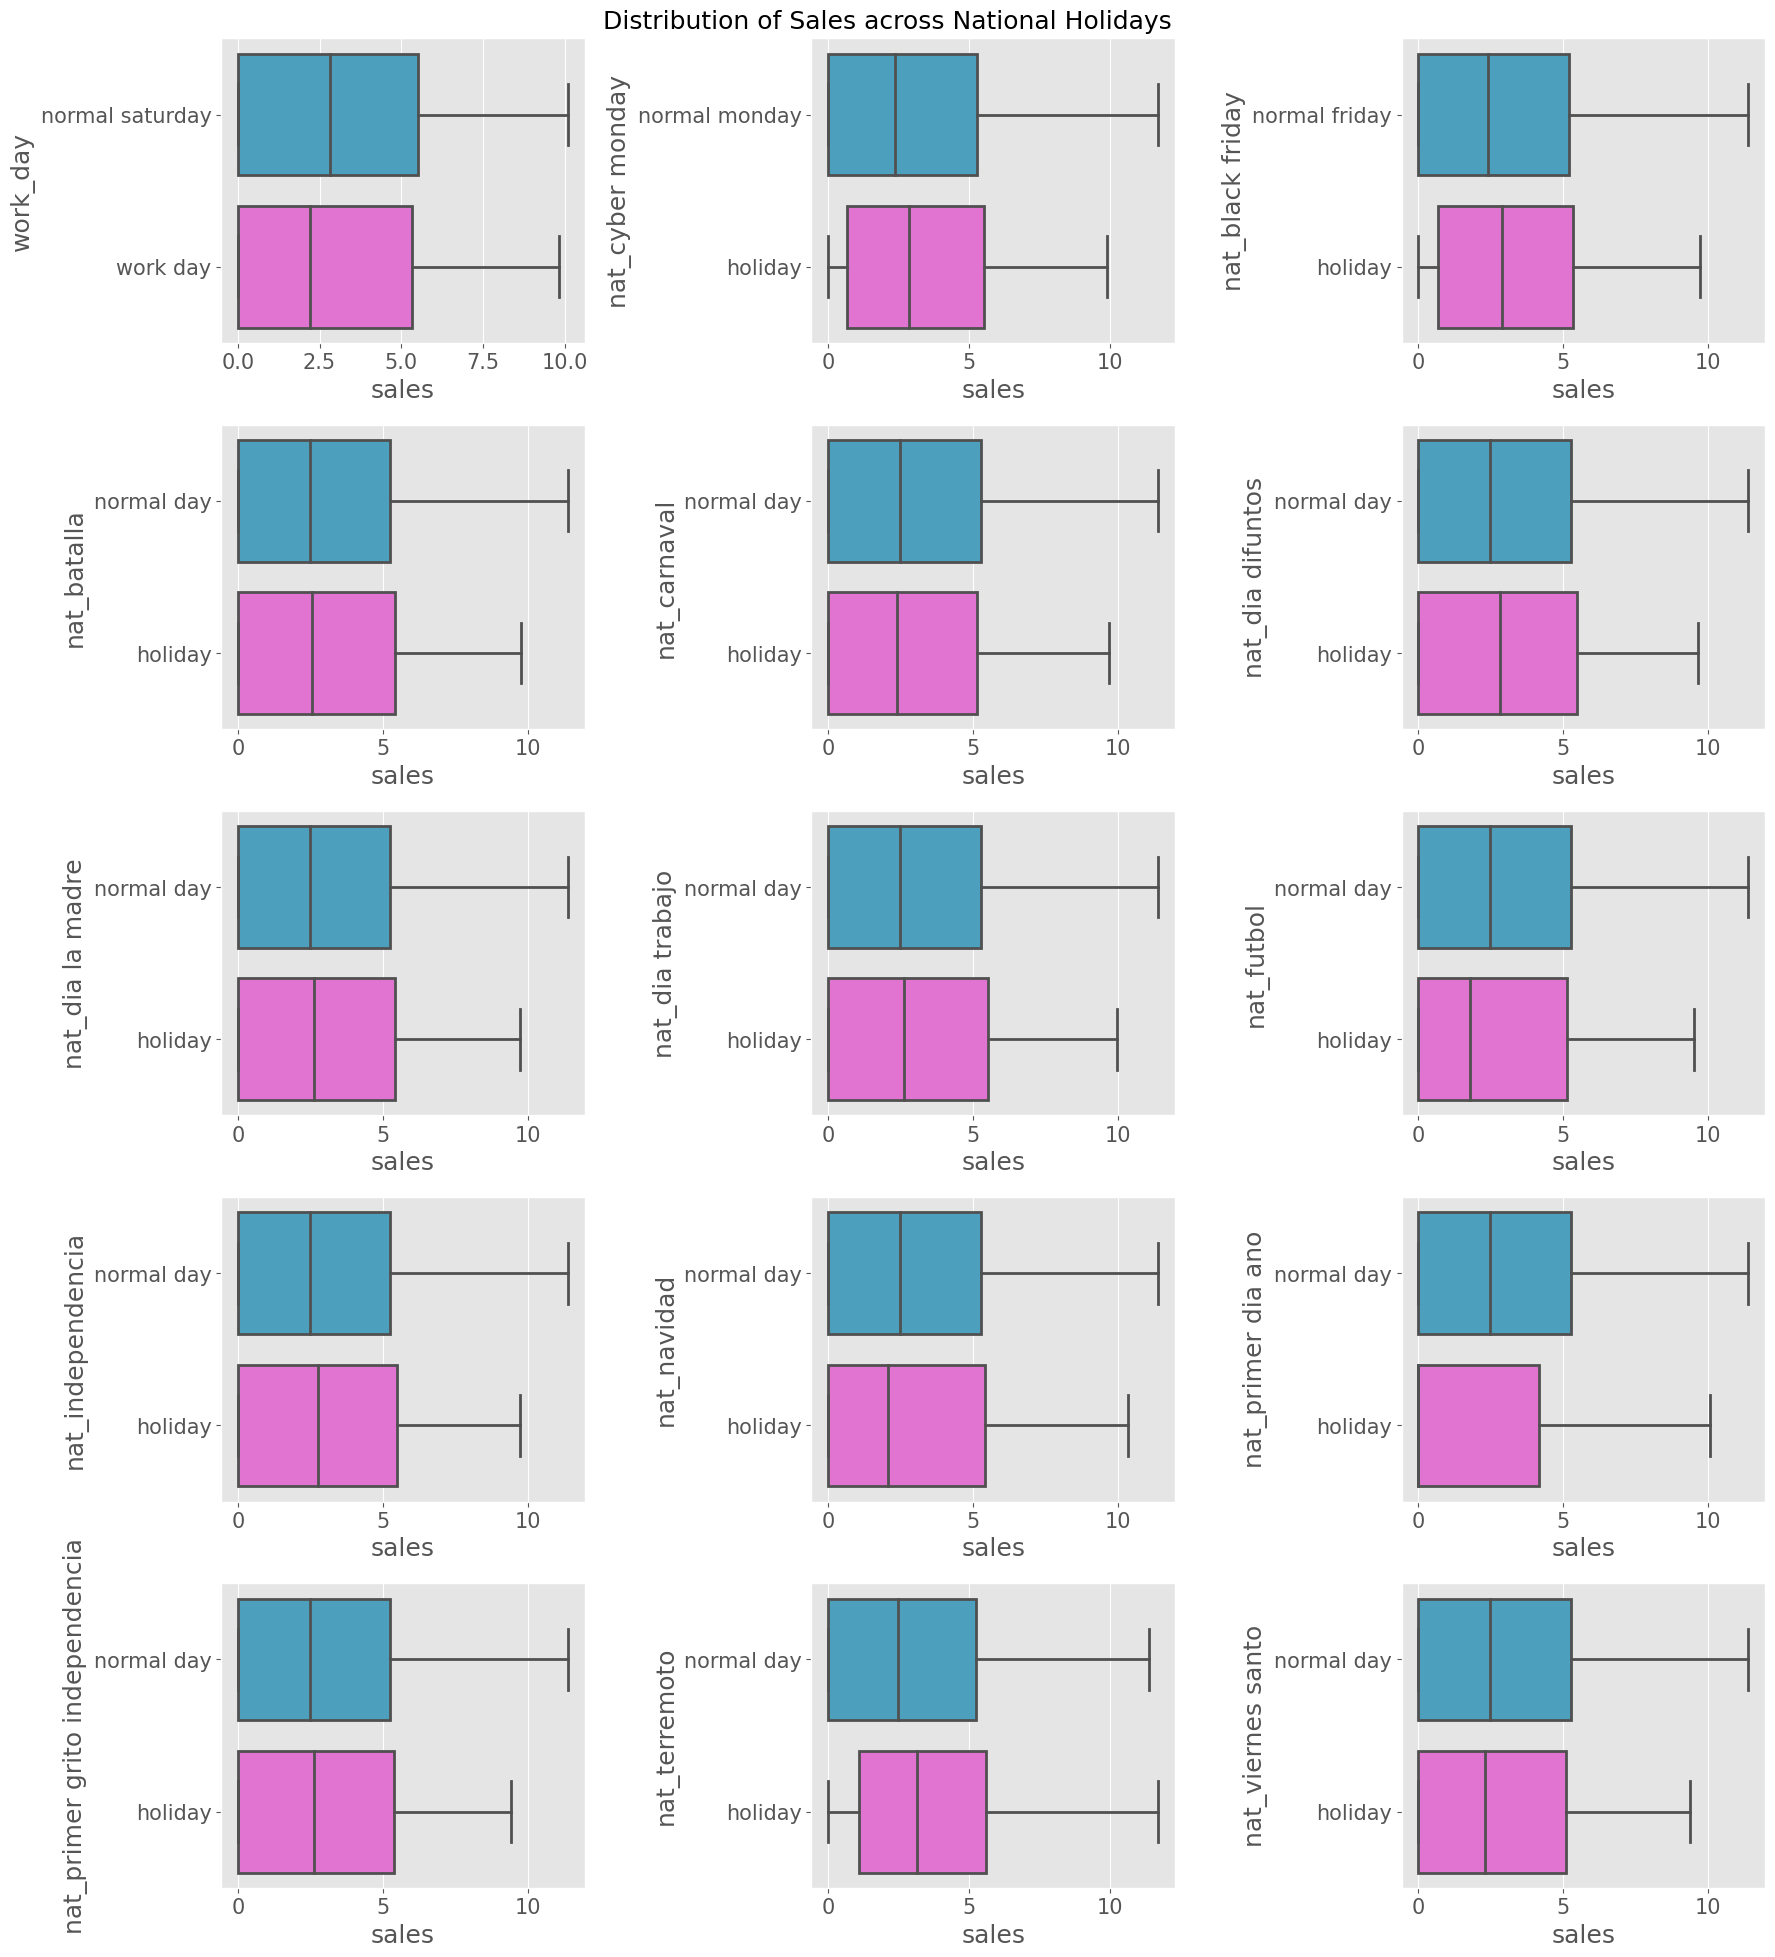

In [84]:
plot_properties = {
        "palette": COLORS[5::2],
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }

fig = plt.figure(figsize=(18, 20))

sns.boxplot(
    data=df[(df.date.dt.weekday.eq(5)) & (df.no_holiday.eq(1))],
    y="work_day",
    x="sales",
    ax=fig.add_subplot(531),
    **plot_properties,
)
plt.yticks([0, 1], ["normal saturday", "work day"])

sns.boxplot(
    data=df[(df.date.dt.weekday.eq(0))],
    y="nat_cyber monday",
    x="sales",
    ax=fig.add_subplot(532),
    **plot_properties,
)
plt.yticks([0, 1], ["normal monday", "holiday"])

sns.boxplot(
    data=df[(df.date.dt.weekday.eq(4))],
    y="nat_black friday",
    x="sales",
    ax=fig.add_subplot(533),
    **plot_properties,
)
plt.yticks([0, 1], ["normal friday", "holiday"])

for i, holiday in enumerate(holiday_list.drop(["nat_cyber monday", "nat_black friday"])):
    sns.boxplot(
        data=df[(df[holiday].eq(1)) | (df.no_holiday.eq(1))],
        y=holiday,
        x="sales",
        ax=fig.add_subplot(5, 3, i + 4),
        **plot_properties
    )
    plt.yticks([0, 1], ["normal day", "holiday"])

plt.suptitle("Distribution of Sales across National Holidays")
plt.tight_layout()
plt.show()

📌 There are some holidays that do not have any impact on the sales, we will drop those and keep others.

📌 Also some holidays have negative impact on sales - nat_futbol

In [156]:
impact_holiday_list = ['nat_batalla', 'nat_cyber monday', 'nat_black friday', 'nat_dia difuntos', 'nat_dia la madre',
                       'nat_dia trabajo', 'nat_futbol', 'nat_independencia', 'nat_navidad', 'nat_primer dia ano',
                       'nat_primer grito independencia', 'nat_terremoto', 'nat_viernes santo']

**Regional holidays:** 

* Let's check the sales distribution with regional holidays

In [87]:
df = train_test_merged.copy()
states_with_regional_holiday = regional_holidays.state.unique()
df = df[df.state.isin(states_with_regional_holiday)]

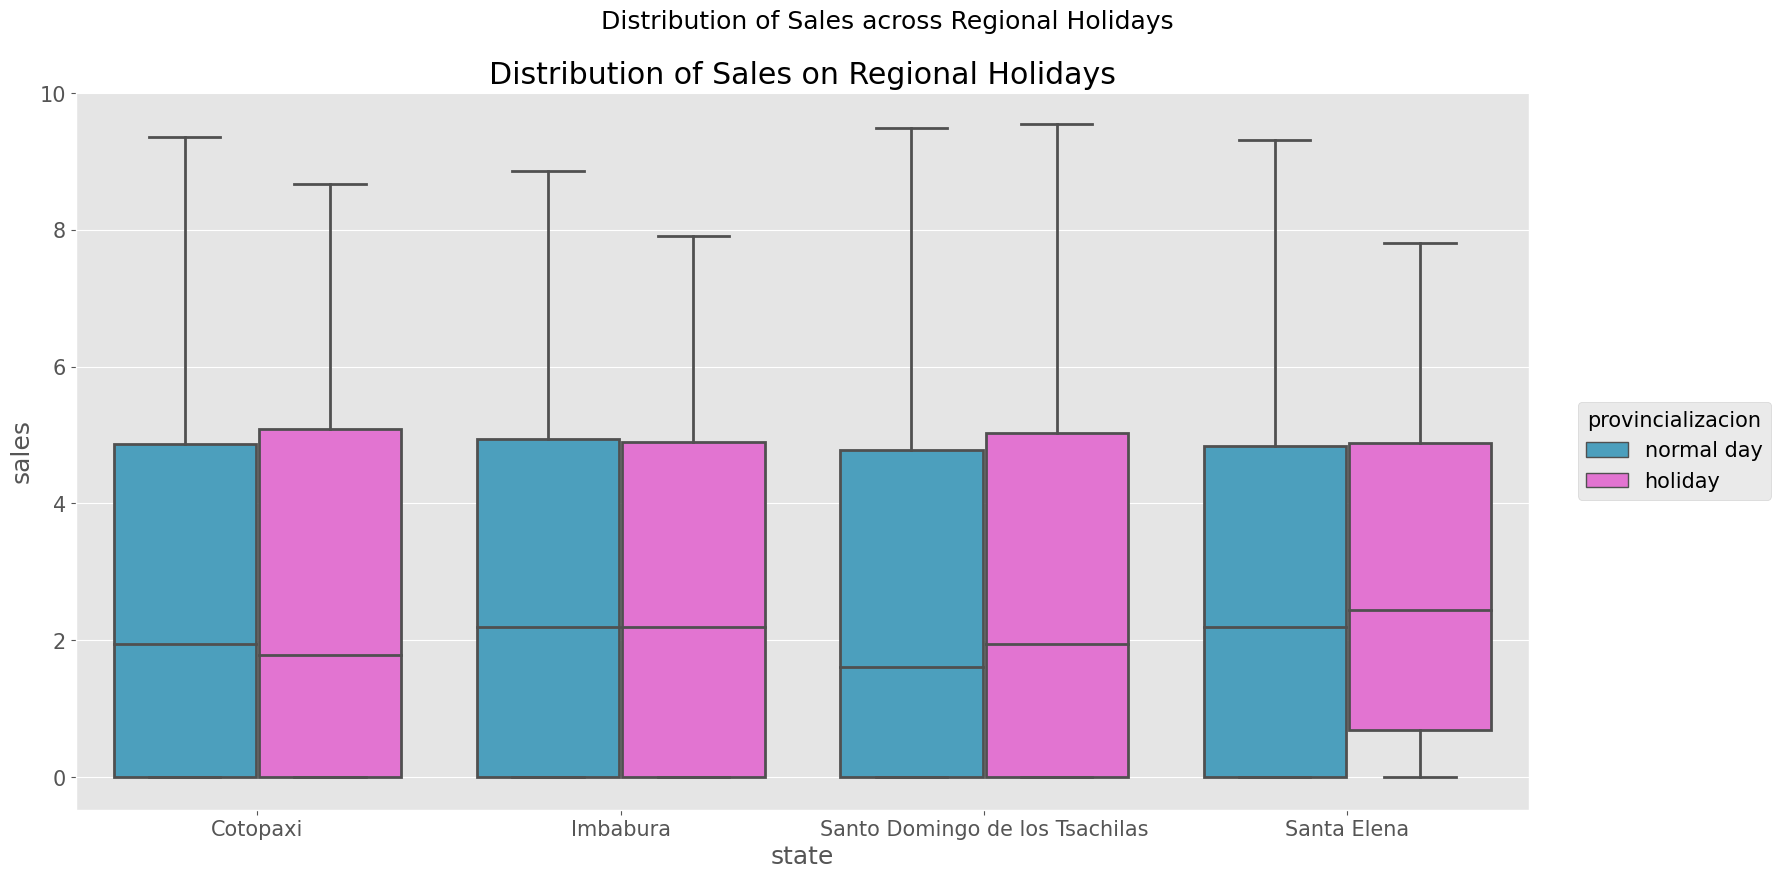

In [88]:
fig = plt.figure(figsize=(18, 9))

sns.boxplot(
        data=df[(df.provincializacion.eq(1)) | (df.no_holiday.eq(1))],
        x="state",
        y="sales",
        hue="provincializacion",
        palette=COLORS[5::2],
        linewidth=2,
        flierprops={"alpha": 0.2},
        ax=fig.add_subplot(111),
    )
plt.title("Distribution of Sales on Regional Holidays")
leg = plt.legend(loc="center", title="provincializacion", bbox_to_anchor=(1.1, 0.5))
leg.texts[0].set_text("normal day")
leg.texts[1].set_text("holiday")

plt.suptitle("Distribution of Sales across Regional Holidays")
plt.tight_layout()
plt.show()

📌 There is a positive impact on sales with regional holidays except Imbabura. 

**Local Holidays:** 

* Let's check the sales distribution with local holidays

In [89]:
df = train_test_merged.copy()
holiday_list = local_holidays.columns[2:]

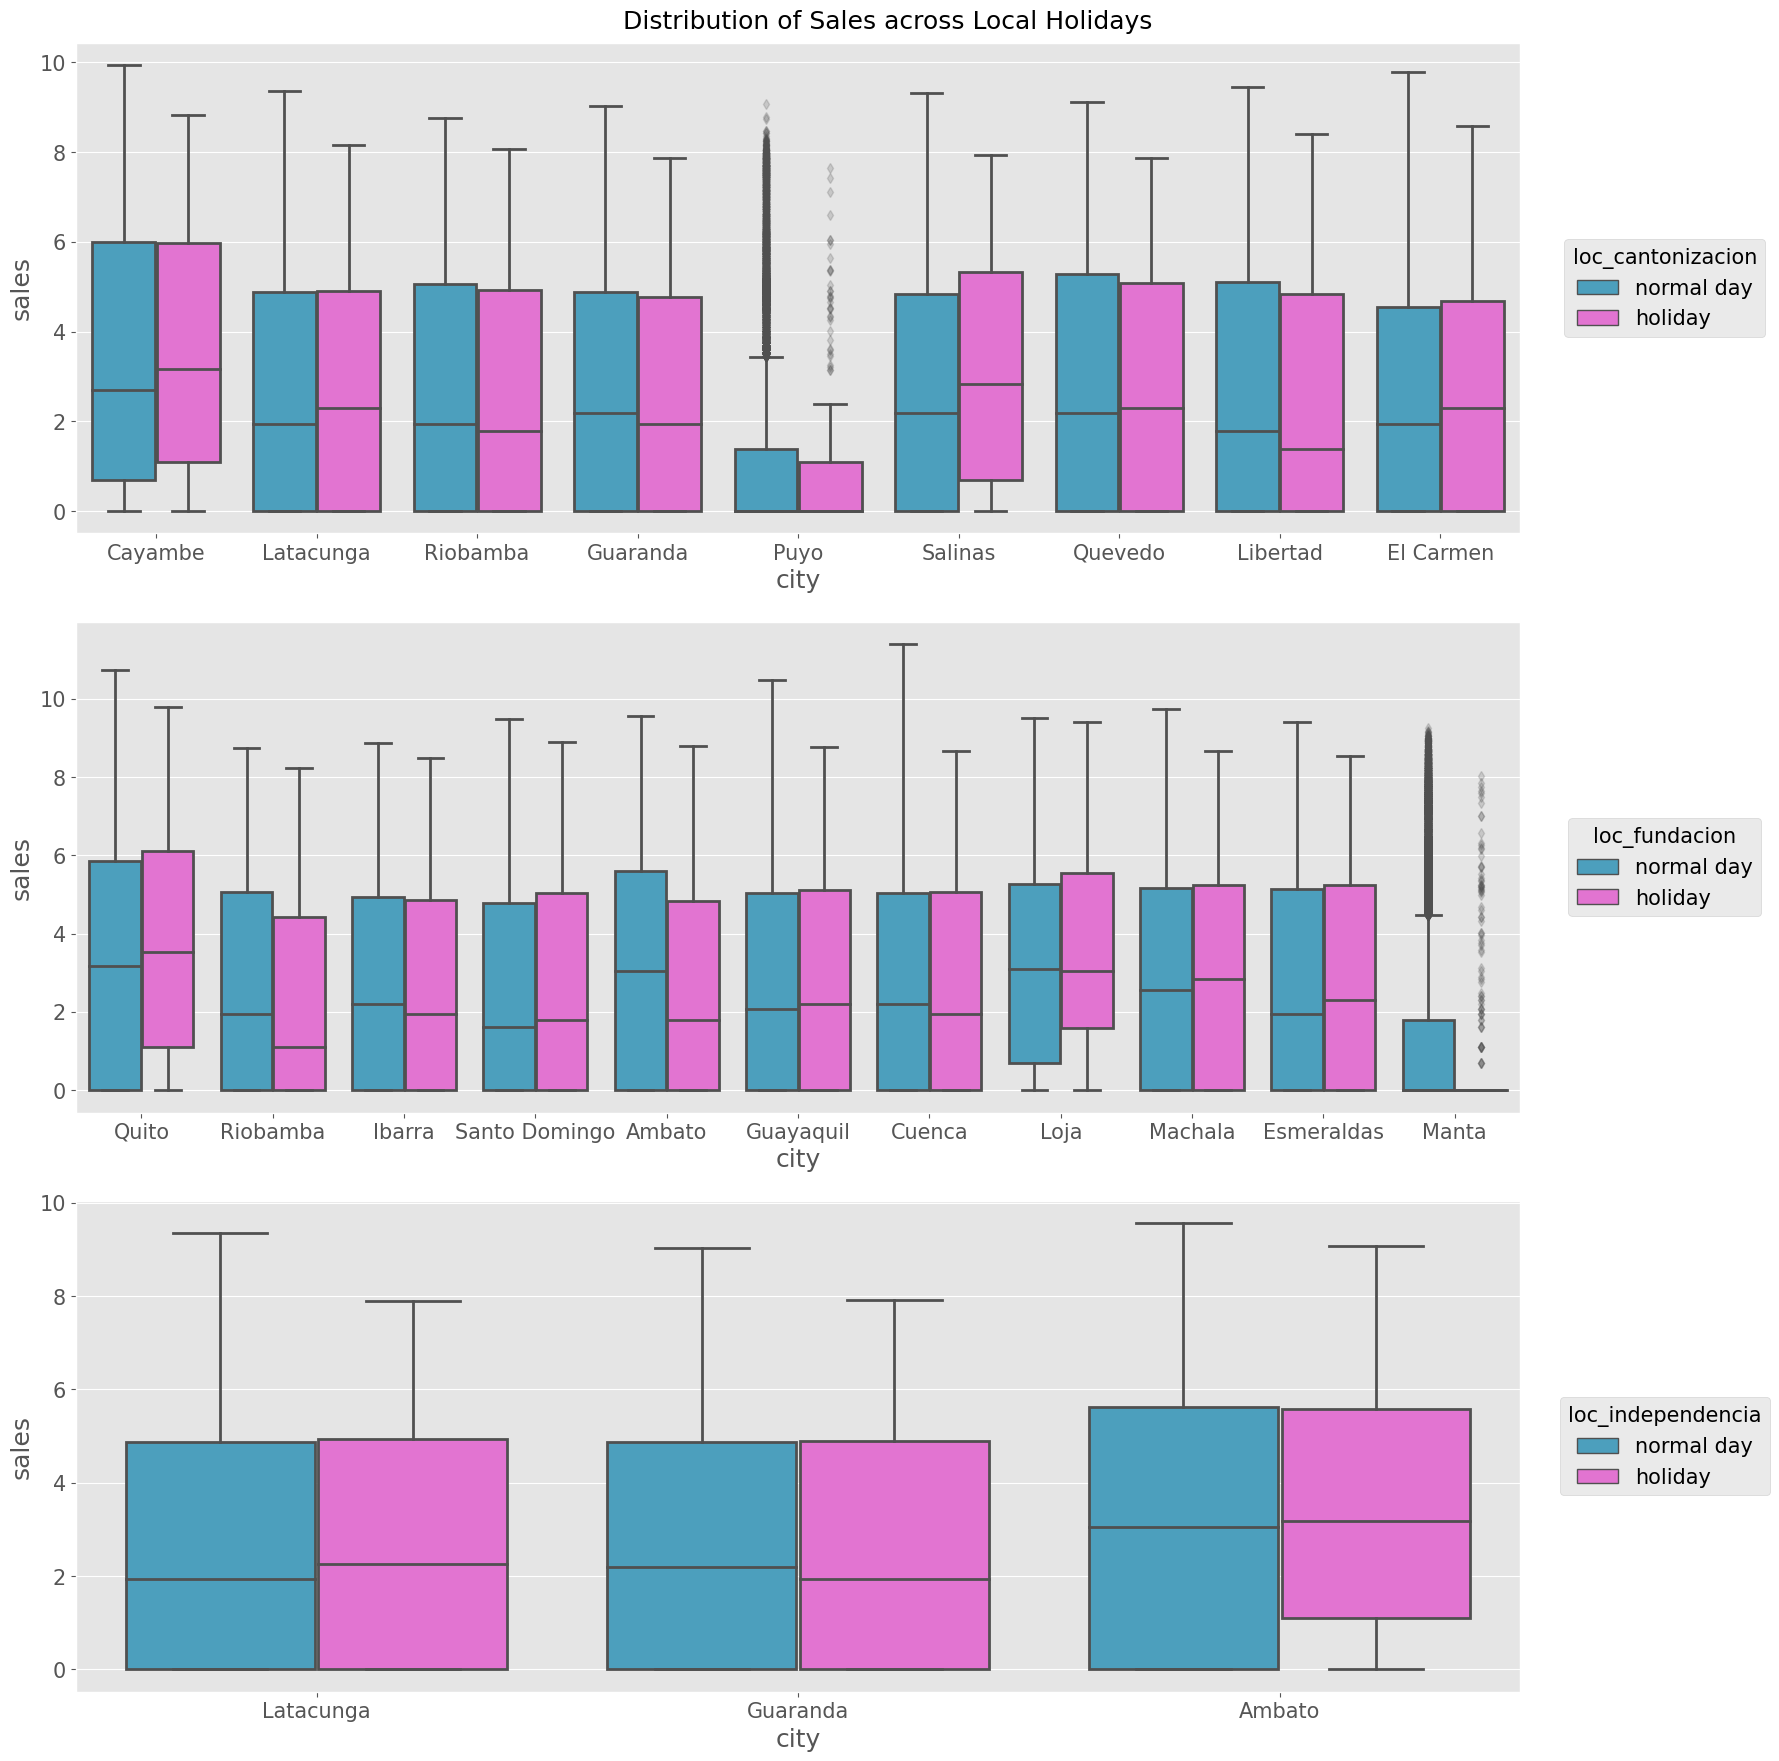

In [90]:
fig = plt.figure(figsize=(18, 18))

for i, holiday in enumerate(holiday_list):
    tmp = df[df.city.isin(local_holidays[local_holidays[holiday].eq(1)].city.unique())]
    sns.boxplot(
        data=tmp[(tmp[holiday].eq(1)) | (tmp.no_holiday.eq(1))],
        x="city",
        y="sales",
        hue=holiday,
        palette=COLORS[5::2],
        linewidth=2,
        flierprops={"alpha": 0.2},
        ax=fig.add_subplot(3, 1, i+1),
    )
    leg = plt.legend(loc="center", title=holiday, bbox_to_anchor=(1.1, 0.5))
    leg.texts[0].set_text("normal day")
    leg.texts[1].set_text("holiday")
    
plt.suptitle("Distribution of Sales across Local Holidays")
plt.tight_layout()
plt.show()

📌 Only some local holidays have positive impact on the sales, we will keep only those

In [91]:
impact_holiday_list.extend(['loc_cantonizacion', 'loc_fundacion'])

📌 **Hypothesis:** 

specific day of week (e.g. - weekend), month (pay day), year (e.g. - days neay new year, chrismas), week of year, month, year should have positive/negative imact on **sales** 

In [92]:
df = train_test_merged.copy().sort_values(["date", "store_nbr", "family"], ignore_index=True)
df = df[df.no_holiday.eq(1)].reset_index(drop=True)

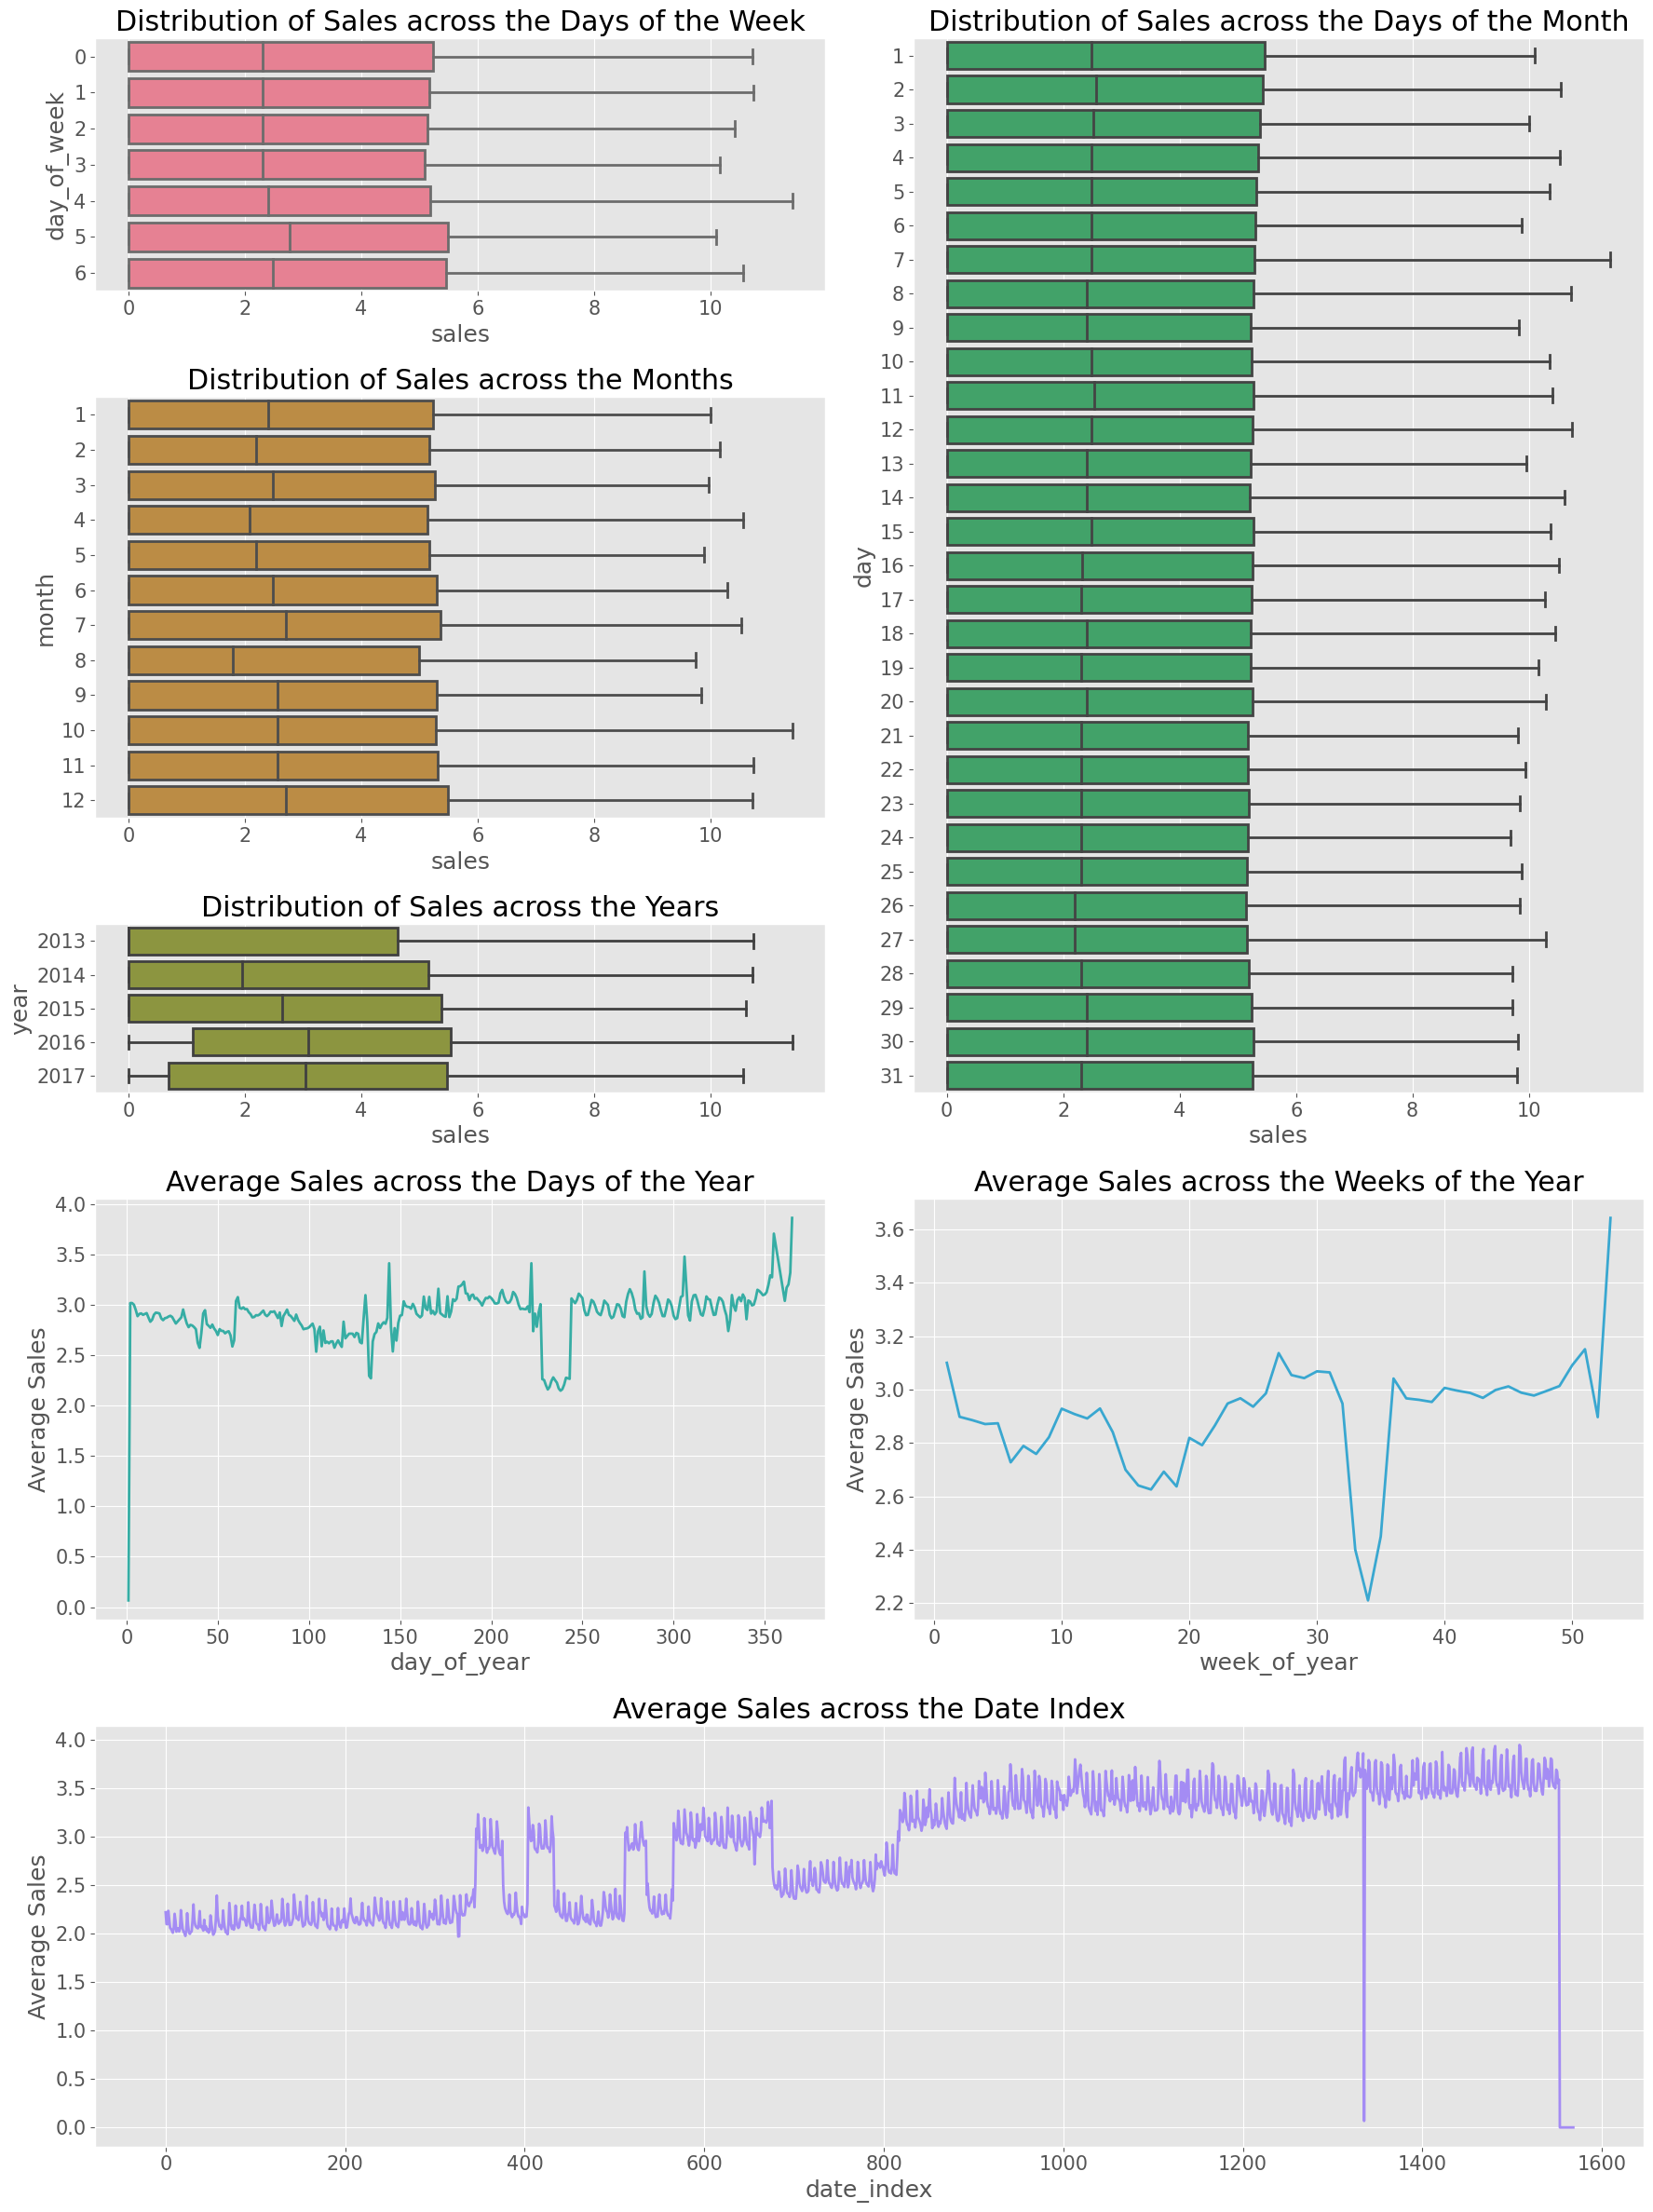

In [93]:
df["day"] = df.date.dt.day
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year
df["day_of_week"] = df.date.dt.dayofweek
df["day_of_year"] = df.date.dt.dayofyear
df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
df["date_index"] = df.date.factorize()[0]

plot_properties = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))

sns.boxplot(
    data=df,
    y="day_of_week",
    x="sales",
    color=COLORS[0],
    ax=fig.add_subplot(gs[0, 0]),
    **plot_properties,
)
plt.title("Distribution of Sales across the Days of the Week")

sns.boxplot(
    data=df,
    y="month",
    x="sales",
    color=COLORS[1],
    ax=fig.add_subplot(gs[1, 0]),
    **plot_properties,
)
plt.title("Distribution of Sales across the Months")

sns.boxplot(
    data=df,
    y="year",
    x="sales",
    color=COLORS[2],
    ax=fig.add_subplot(gs[2, 0]),
    **plot_properties,
)
plt.title("Distribution of Sales across the Years")

sns.boxplot(
    data=df,
    y="day",
    x="sales",
    color=COLORS[3],
    ax=fig.add_subplot(gs[:3, 1]),
    **plot_properties,
)
plt.title("Distribution of Sales across the Days of the Month")

sns.lineplot(
    data=df.groupby("day_of_year").sales.mean().reset_index(),
    x="day_of_year",
    y="sales",
    color=COLORS[4],
    ax=fig.add_subplot(gs[3, 0]),
    linewidth=2,
)
plt.ylabel("Average Sales")
plt.title("Average Sales across the Days of the Year")

sns.lineplot(
    data=df.groupby("week_of_year").sales.mean().reset_index(),
    x="week_of_year",
    y="sales",
    color=COLORS[5],
    ax=fig.add_subplot(gs[3, 1]),
    linewidth=2,
)
plt.ylabel("Average Sales")
plt.title("Average Sales across the Weeks of the Year")

sns.lineplot(
    data=df.groupby("date_index").sales.mean().reset_index(),
    x="date_index",
    y="sales",
    color=COLORS[6],
    ax=fig.add_subplot(gs[4, :]),
    linewidth=2,
)
plt.ylabel("Average Sales")
plt.title("Average Sales across the Date Index")

plt.tight_layout()
plt.show()

📌 We can see the jump in sales at the weekends

📌 Similarly we can see jumps near pay days (15th and month end/start)

📌 Also there is a jump in sales at the last week of the year

In [94]:
impact_holiday_list
holidays_to_drop = list(set(local_holidays.drop(columns=["date", "city"]).columns).difference(set(impact_holiday_list)))
holidays_to_drop.extend(list(set(national_holidays.drop(columns=["date"]).columns).difference(impact_holiday_list)))
holidays_to_drop

['loc_independencia', 'nat_carnaval']

* Let's drop the holidays that we dont want to include in our modeling

In [95]:
train_test_merged.drop(columns=[*holidays_to_drop], inplace=True)

In [96]:
train_test_merged = train_test_merged.sort_values(["date", "store_nbr", "family"], ignore_index=True)

train_test_merged["day"] = train_test_merged.date.dt.day
train_test_merged["month"] = train_test_merged.date.dt.month
train_test_merged["year"] = train_test_merged.date.dt.year
train_test_merged["day_of_week"] = train_test_merged.date.dt.dayofweek
train_test_merged["day_of_year"] = train_test_merged.date.dt.dayofyear
train_test_merged["week_of_year"] = train_test_merged.date.dt.isocalendar().week.astype(int)
train_test_merged["date_index"] = train_test_merged.date.factorize()[0]

In [97]:
train_test_merged.head()

,date,store_nbr,family,id,sales,onpromotion,train_test_id,city,state,type,...,nat_terremoto,nat_viernes santo,no_holiday,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0,1,1,2013,1,1,1,0
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0,1,1,2013,1,1,1,0
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0,1,1,2013,1,1,1,0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0,1,1,2013,1,1,1,0
4,2013-01-01,1,BOOKS,4.0,0.0,0.0,train,Quito,Pichincha,D,...,0.0,0.0,0,1,1,2013,1,1,1,0


<p style="font-size:25px; color:#496595">Transforming the Data</p>

* We need to transform the data to get an individual time serries for each **store_nbr** and **family** combination.

In [158]:
train_test_merged.store_nbr.nunique() * train_test_merged.family.nunique()

1782

* We will get total **1782** time serries

In [149]:
train_test_merged_wide = pd.pivot(train_test_merged[train_test_merged.date.ge(pd.to_datetime("15-08-2016"))], index="date", columns=["store_nbr", "family"])

In [150]:
# series for series in train_test_merged
store_list = train_test_merged.store_nbr.unique().tolist()
family_list = train_test_merged.family.unique().tolist()
combinations = list(itertools.product(store_list, family_list))
continuos_columns = ['sales', 'onpromotion', 'train_test_id', 'dcoilwtico',
                     'work_day', 'loc_cantonizacion', 'loc_fundacion', 'provincializacion',
                     'nat_batalla', 'nat_cyber monday', 'nat_dia difuntos', 'nat_dia la madre',
                     'nat_dia trabajo', 'nat_futbol', 'nat_independencia', 'nat_navidad',
                     'nat_primer grito independencia', 'nat_terremoto', 'no_holiday', 'day', 'month',
                     'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index']
modal_datasets = {}

def assign_df(store, family):
    modal_datasets[f"{store}@{family}"] = pd.DataFrame()
    for col in continuos_columns:
        modal_datasets[f"{store}@{family}"][col] = train_test_merged_wide[col][store][family]
        modal_datasets[f"{store}@{family}"]["lag_7"] = modal_datasets[f"{store}@{family}"]["sales"].shift(7).fillna(0)
        # modal_datasets[f"{store}@{family}"]["lag_14"] = modal_datasets[f"{store}@{family}"]["sales"].shift(14).fillna(0)
        # modal_datasets[f"{store}@{family}"]["lag_21"] = modal_datasets[f"{store}@{family}"]["sales"].shift(21).fillna(0)
        modal_datasets[f"{store}@{family}"]["lag_30"] = modal_datasets[f"{store}@{family}"]["sales"].shift(30).fillna(0)
        modal_datasets[f"{store}@{family}"]["lag_365"] = modal_datasets[f"{store}@{family}"]["sales"].shift(365).fillna(0)
        modal_datasets[f"{store}@{family}"]["lag_730"] = modal_datasets[f"{store}@{family}"]["sales"].shift(730).fillna(0)
    
for store, family in tqdm_notebook(combinations, desc="Extracting Target Series"):
    pool_executor.submit(assign_df(store, family))
    

Extracting Target Series:   0%|          | 0/1782 [00:00<?, ?it/s]

* Let's check a sample time serries for **store_nbr** = 1 and **family** = AUTOMOTIVE

In [151]:
modal_datasets['1@AUTOMOTIVE'].head()

,sales,lag_7,lag_30,lag_365,lag_730,onpromotion,train_test_id,dcoilwtico,work_day,loc_cantonizacion,...,nat_primer grito independencia,nat_terremoto,no_holiday,day,month,year,day_of_week,day_of_year,week_of_year,date_index
date,,,,,,,,,,,,,,,,,,,,,
2016-08-15,1.609438,0.0,0.000000,0.000000,0.0,0.0,train,3.844172,0.0,0.0,...,0.0,0.0,1,15,8,2016,0,228,33,1322
2016-08-16,1.791759,0.0,0.000000,0.000000,0.0,0.0,train,3.862202,0.0,0.0,...,0.0,0.0,1,16,8,2016,1,229,33,1323
2016-08-17,1.609438,0.0,0.000000,0.000000,0.0,0.0,train,3.867235,0.0,0.0,...,0.0,0.0,1,17,8,2016,2,230,33,1324
2016-08-18,1.945910,0.0,0.000000,0.000000,0.0,0.0,train,3.895894,0.0,0.0,...,0.0,0.0,1,18,8,2016,3,231,33,1325
2016-08-19,2.564949,0.0,0.000000,0.000000,0.0,0.0,train,3.901569,0.0,0.0,...,0.0,0.0,1,19,8,2016,4,232,33,1326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,0.000000,0.0,2.079442,0.693147,0.0,0.0,test,3.867374,0.0,0.0,...,0.0,0.0,1,27,8,2017,6,239,34,1699
2017-08-28,0.000000,0.0,1.609438,1.098612,0.0,0.0,test,3.858622,0.0,0.0,...,0.0,0.0,1,28,8,2017,0,240,35,1700
2017-08-29,0.000000,0.0,0.693147,2.079442,0.0,0.0,test,3.859887,0.0,0.0,...,0.0,0.0,1,29,8,2017,1,241,35,1701


* We have modal datasets, now let's start with model building

<p style="font-size:25px; color:#496595">Base Model: Linear Regression</p>

In [159]:
# Function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(actual, preds):
    for i in range(0,len(preds)):
        if preds[i]<0:
            preds[i] = 0
        else:
            pass
    
    error = (math.sqrt(mean_squared_log_error(actual, preds)))
    return error


In [153]:
def model_training(model_name, key, df, model):
    # We will first separate the target variable from the features
    y = df['sales']
    x = df.drop(columns=['sales'])

    train_len = math.ceil(x.shape[0] * 0.9)
    valid_len = x.shape[0] - train_len

    train_x = x.iloc[:train_len]
    train_y = y.iloc[:train_len]

    valid_x = x.iloc[train_len:]
    valid_y = y.iloc[train_len:]


    model.fit(train_x, train_y)
    preds = model.predict(valid_x)

    # results
    score = rmsle(valid_y, preds)

    print(f"{key}: RMSLE for {model_name}: {score}")

In [154]:
# Fit Linear Regression Model

for key, value in tqdm_notebook(modal_datasets.items()):
    df = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df.loc_cantonizacion = df.loc_cantonizacion.astype("int")
    df.loc_fundacion = df.loc_fundacion.astype("int")
    model_training("Linear Regression", key, df, LinearRegression())

  0%|          | 0/1782 [00:00<?, ?it/s]

1@AUTOMOTIVE: RMSLE for Linear Regression: 3.7891848611939967
1@BABY CARE: RMSLE for Linear Regression: 0.0
1@BEAUTY: RMSLE for Linear Regression: 0.2428800306377581
1@BEVERAGES: RMSLE for Linear Regression: 3.1831086104472432
1@BOOKS: RMSLE for Linear Regression: 1.789583257952141
1@BREAD/BAKERY: RMSLE for Linear Regression: 3.229941048581759
1@CELEBRATION: RMSLE for Linear Regression: 0.421529853158434
1@CLEANING: RMSLE for Linear Regression: 3.260463347894407
1@DAIRY: RMSLE for Linear Regression: 0.46405999303467604
1@DELI: RMSLE for Linear Regression: 2.963012638283474
1@EGGS: RMSLE for Linear Regression: 3.3757177748837606
1@FROZEN FOODS: RMSLE for Linear Regression: 1.5149184407053229
1@GROCERY I: RMSLE for Linear Regression: 3.0571193918947674
1@GROCERY II: RMSLE for Linear Regression: 3.5201201333514254
1@HARDWARE: RMSLE for Linear Regression: 0.36270725238197904
1@HOME AND KITCHEN I: RMSLE for Linear Regression: 3.8829841257927162
1@HOME AND KITCHEN II: RMSLE for Linear Regres

<p style="font-size:25px; color:#496595">XGB Regressor</p>

In [155]:
for key, value in tqdm_notebook(modal_datasets.items()):
    df = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df.loc_cantonizacion = df.loc_cantonizacion.astype("int")
    df.loc_fundacion = df.loc_fundacion.astype("int")
    pool_executor.submit(model_training("XGBRegressor", key, df, model=xgb.XGBRegressor()))

  0%|          | 0/1782 [00:00<?, ?it/s]

1@AUTOMOTIVE: RMSLE for XGBRegressor: 0.22488316248267676
1@BABY CARE: RMSLE for XGBRegressor: 1.840638063888261e-16
1@BEAUTY: RMSLE for XGBRegressor: 0.2423539735029189
1@BEVERAGES: RMSLE for XGBRegressor: 0.018120874341605687
1@BOOKS: RMSLE for XGBRegressor: 0.23059702642801208
1@BREAD/BAKERY: RMSLE for XGBRegressor: 0.02781355354802338
1@CELEBRATION: RMSLE for XGBRegressor: 0.33730236653625917
1@CLEANING: RMSLE for XGBRegressor: 0.025620165891150633
1@DAIRY: RMSLE for XGBRegressor: 0.024300966331223518
1@DELI: RMSLE for XGBRegressor: 0.039256000434301774
1@EGGS: RMSLE for XGBRegressor: 0.03850866286060261
1@FROZEN FOODS: RMSLE for XGBRegressor: 0.04273011339501515
1@GROCERY I: RMSLE for XGBRegressor: 0.020317082410102452
1@GROCERY II: RMSLE for XGBRegressor: 0.10461049830778672
1@HARDWARE: RMSLE for XGBRegressor: 0.42333894138465655
1@HOME AND KITCHEN I: RMSLE for XGBRegressor: 0.16153297649863202
1@HOME AND KITCHEN II: RMSLE for XGBRegressor: 0.0872233882804054
1@HOME APPLIANCES: R

<p style="font-size:25px; color:#496595">Model Predictions</p>

* Let's fitt the model on the etire data and predict the sales for the test data

In [156]:
test_pred_wide = pd.pivot(train_test_merged[train_test_merged.train_test_id.eq("test")][["date", "store_nbr", "family", "sales"]], index="date", columns=["store_nbr", "family"], values="sales")

In [160]:
# Function to transform the predictions back to original scale
def inverse_transform(store,family, preds):
    for i in range(0,len(preds)):
        if preds[i]<0:
            preds[i] = 0
        else:
            pass
    test_pred_wide[int(store), family] = np.expm1(preds)
    

In [161]:
# Function to train the model and predict on test data
def model_predictions(key, df_train, df_test, model):
    # We will first separate the target variable from the features
    train_y = df_train['sales']
    train_x = df_train.drop(columns=['sales'])

    test_x = df_test.drop(columns=['sales'])


    model.fit(train_x, train_y)
    preds = model.predict(test_x)

    return preds

In [162]:
# Function to transform the predictions back to original structure
def transform_and_save_preds(name):
    test_pred_scaled = test_pred_wide.melt(
        value_name="sales", ignore_index=False,
    ).reset_index()
    
    test_with_sales = test.merge(
        test_pred_scaled,
        on=["date", "store_nbr", "family"],
        how="left"
    )
    sample_submission.sales = test_with_sales.sales

    sample_submission.to_csv(f"submission_{name}.csv", index=False)

<p style="font-size:25px; color:#496595">Model Predictions: Linear Regression</p>

In [163]:
# Linear Regression
for key, value in tqdm_notebook(modal_datasets.items()):
    store,family = (key.split("@"))
    
    df_train = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df_train.loc_cantonizacion = df_train.loc_cantonizacion.astype("int")
    df_train.loc_fundacion = df_train.loc_fundacion.astype("int")
    
    df_test = value[value.train_test_id.eq("test")].drop(columns=["train_test_id"])
    df_test.loc_cantonizacion = df_test.loc_cantonizacion.astype("int")
    df_test.loc_fundacion = df_test.loc_fundacion.astype("int")
    pool_executor.submit(inverse_transform(store, family, model_predictions(key, df_train, df_test, model=LinearRegression())))

  0%|          | 0/1782 [00:00<?, ?it/s]

In [164]:
transform_and_save_preds("LR_log")

<p style="font-size:25px; color:#496595">Model Predictions: XGB Regressor</p>

In [165]:
# XGBRegressor
for key, value in tqdm_notebook(modal_datasets.items()):
    store,family = (key.split("@"))
    
    df_train = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df_train.loc_cantonizacion = df_train.loc_cantonizacion.astype("int")
    df_train.loc_fundacion = df_train.loc_fundacion.astype("int")
    
    df_test = value[value.train_test_id.eq("test")].drop(columns=["train_test_id"])
    df_test.loc_cantonizacion = df_test.loc_cantonizacion.astype("int")
    df_test.loc_fundacion = df_test.loc_fundacion.astype("int")
    
    pool_executor.submit(inverse_transform(store, family, model_predictions(key, df_train, df_test, model=xgb.XGBRegressor(random_state=50))))

  0%|          | 0/1782 [00:00<?, ?it/s]

In [166]:
transform_and_save_preds("XGB_log")

<p style="font-size:25px; color:#496595">Model Predictions: Decision Tree Regressor</p>

In [167]:
# DecisionTreeRegressor
for key, value in tqdm_notebook(modal_datasets.items()):
    store,family = (key.split("@"))
    
    df_train = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df_train.loc_cantonizacion = df_train.loc_cantonizacion.astype("int")
    df_train.loc_fundacion = df_train.loc_fundacion.astype("int")
    
    df_test = value[value.train_test_id.eq("test")].drop(columns=["train_test_id"])
    df_test.loc_cantonizacion = df_test.loc_cantonizacion.astype("int")
    df_test.loc_fundacion = df_test.loc_fundacion.astype("int")
    
    pool_executor.submit(inverse_transform(store, family, model_predictions(key, df_train, df_test, model=DecisionTreeRegressor(random_state=50))))

  0%|          | 0/1782 [00:00<?, ?it/s]

In [168]:
transform_and_save_preds("DT_log")

<p style="font-size:25px; color:#496595">Model Predictions: LGBM Regressor</p>

In [169]:
# LGBMRegressor
for key, value in tqdm_notebook(modal_datasets.items()):
    store,family = (key.split("@"))
    
    df_train = value[value.train_test_id.eq("train")].drop(columns=["train_test_id"])
    df_train.loc_cantonizacion = df_train.loc_cantonizacion.astype("int")
    df_train.loc_fundacion = df_train.loc_fundacion.astype("int")
    
    df_test = value[value.train_test_id.eq("test")].drop(columns=["train_test_id"])
    df_test.loc_cantonizacion = df_test.loc_cantonizacion.astype("int")
    df_test.loc_fundacion = df_test.loc_fundacion.astype("int")
    
    pool_executor.submit(inverse_transform(store, family, model_predictions(key, df_train, df_test, model=LGBMRegressor())))

  0%|          | 0/1782 [00:00<?, ?it/s]

In [170]:
transform_and_save_preds("LGB_log")

<p style="font-size:25px; color:#496595">Ensembling the models: XGB + LGB</p>

In [3]:
df_xgb = pd.read_csv("submission_XGB_log_0.482.csv")
df_xgb.head()

,id,sales
0,3000888,1.234667
1,3000889,0.000000
2,3000890,9.002883
3,3000891,2190.621800
4,3000892,0.050674


In [4]:
df_lgb = pd.read_csv("submission_LGB_log.csv")
df_lgb.head()

,id,sales
0,3000888,3.605457
1,3000889,0.000000
2,3000890,5.276628
3,3000891,2309.098328
4,3000892,0.057452


In [5]:
df_sub = pd.DataFrame()
df_sub['id'] = df_xgb['id']
df_sub['sales'] = (df_xgb['sales'] + df_lgb['sales'])/2

In [6]:
df_sub.to_csv('submission_ENS_LGB_XGB.csv', index=False)

<p style="font-size:25px; color:#496595">Score on Kaggel: 0.43135</p>